## 1. ARIMA 모델의 정의

Trend와 Seasonality를 잘 분리해 낸 경우 Residual이 예측력 있는 안정적인 시계열 데이터가 되는 것을 확인하다.

ARIMA(Autoregressive Integrated Moving Average)를 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있다.


ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average) 

### 1-1. AR(자기회귀, Autoregressive)


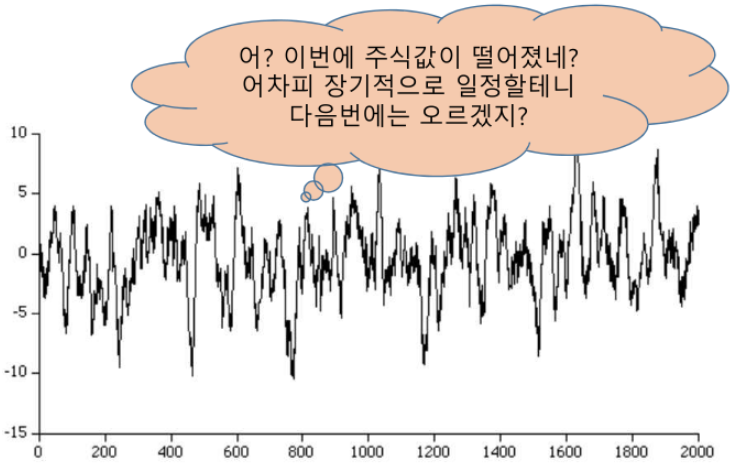


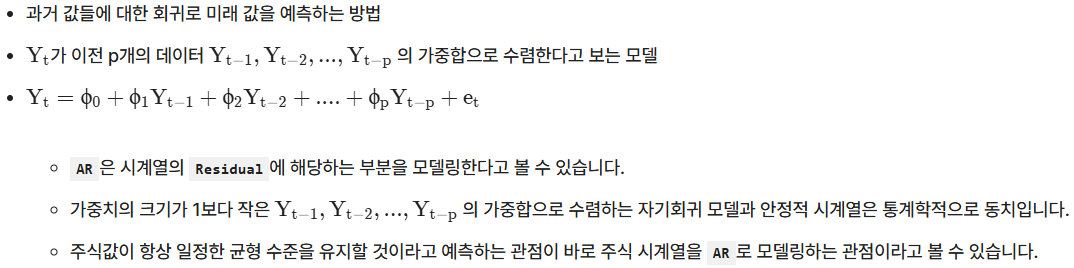


### 1-2 MA(이동평균, Moving Average)

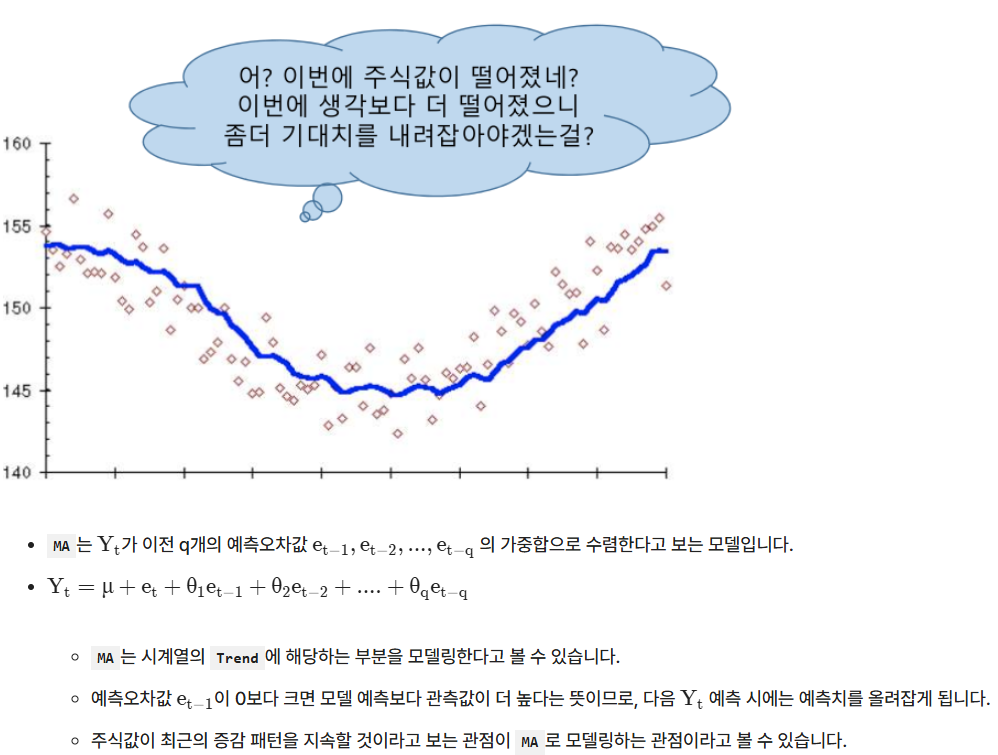


### 1-3    I   (차분 누적, Integration)

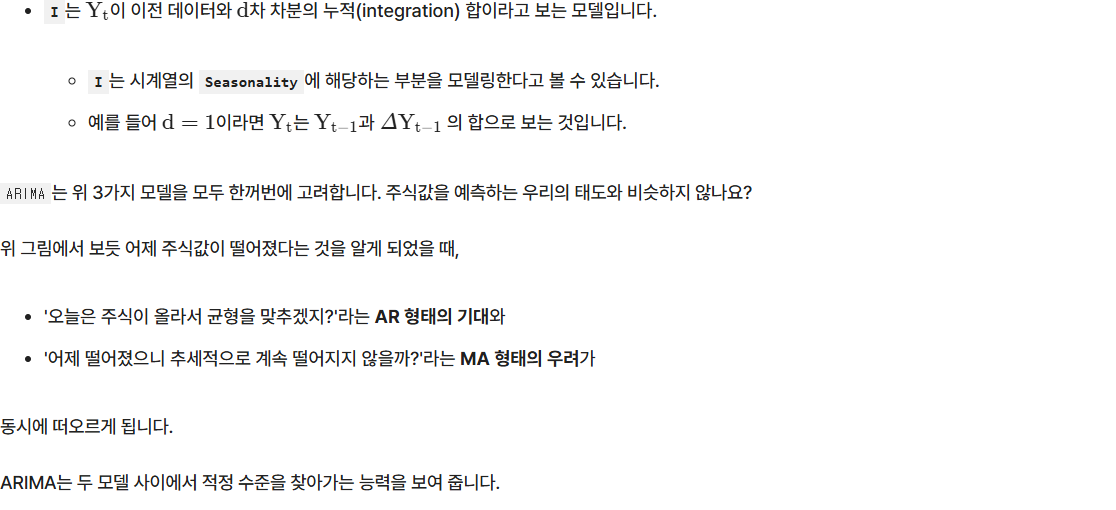

## 2. ARIMA 모델의 모수  - p, q, d

* p : 자기회귀 모형(AR)의 시차
* d : 차분 누적(I) 횟수
* q : 이동평균 모형(MA)의 시차


이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문.


모수 p, q, d는 어떻게 결정될까?


대표적으로,
* ACF(Autocorrelation Function) - 자기상관함수 :  k 시차로, 이는 k 구간인 계열 값 사이의 상관관계입니다.
    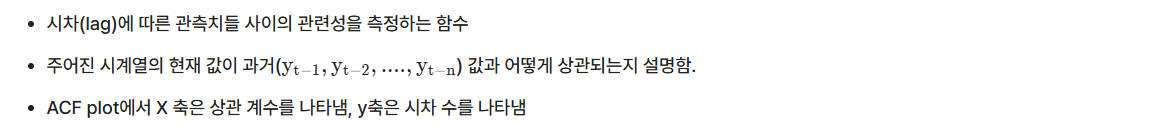
* PACF(Partial Autocorrelation Function) - 편자기상관함수 : k 시차로, 이는 k 구간(사이의 구간 값 고려)인 계열 값 사이의 상관관계입니다.
    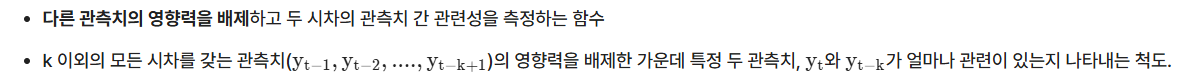




International airline passengers 시계열을 예시를 들어 설명하겠습니다. 우리는 statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용할 것입니다.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)

ts2 = df['Passengers']
ts_log = np.log(ts2)

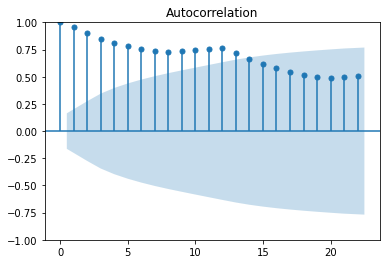

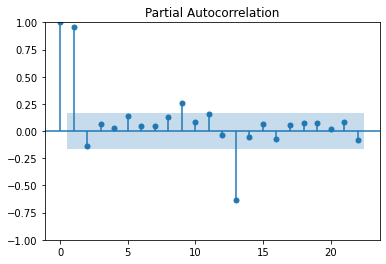

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

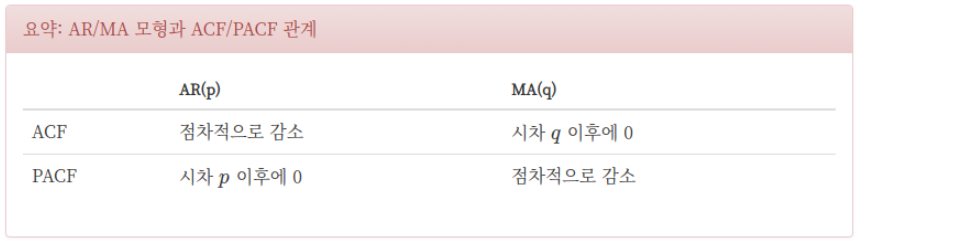

이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.
반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠습니다.



d 구하기.

d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 함.

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Month'>

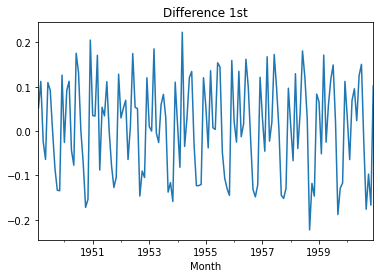

In [6]:
# 1차 차분 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]

diff_1.plot(title='Difference 1st')

<AxesSubplot:title={'center':'Difference 2st'}, xlabel='Month'>

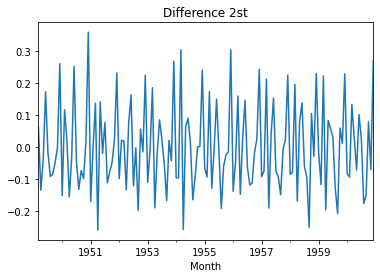

In [7]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2st')

## 3. 학습 데이터 분리

학습과 테스트에 9:1로

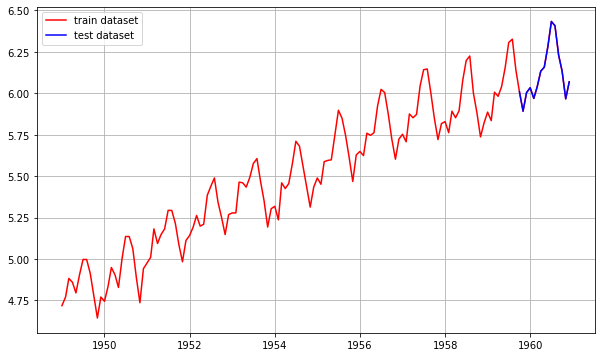

In [12]:
train_data , test_data = ts_log[:int(len(ts_log)*0.9)] , ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))

plt.grid(True)
plt.plot(ts_log, c='r', label='train dataset')
plt.plot(test_data, c='b', label='test dataset')

plt.legend()

In [13]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## 4. ARIMA 모델 훈련과 추론

In [19]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # p , d , q 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.942
Date:                Thu, 12 Dec 2024   AIC                           -409.883
Time:                        09:50:48   BIC                           -367.103
Sample:                    01-01-1949   HQIC                          -392.502
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2651      0.081     -3.277      0.001      -0.424      -0.107
ar.L2         -0.0044      0.108     -0.040      0.968      -0.216       0.208
ar.L3          0.0021      0.046      0.046      0.9

Dep. Variable (종속 변수): 분석된 시계열 데이터의 변수 이름입니다. 여기서는 'Passengers'로 되어 있습니다.

No. Observations (관측치 수): 모델이 사용한 데이터 포인트의 수입니다. 이 경우 129개입니다.

Model (모델): 사용된 ARIMA 모델의 파라미터(AR, I, MA)를 나타냅니다. ARIMA(14, 1, 0)으로 14차의 자기회귀, 1차 차분, 0차 이동평균을 사용한 모델입니다.

Log Likelihood (로그 우도): 모델이 데이터에 얼마나 적합한지를 나타내는 지표로, 값이 클수록 모델이 적합하다고 볼 수 있습니다.

AIC, BIC, HQIC: 모델의 적합도를 평가하는 기준입니다. AIC와 BIC가 낮을수록 더 좋은 모델로 평가됩니다.

Coefficients (계수): 각 자기회귀 변수(AR.L1, AR.L2 등) 및 그에 해당하는 계수입니다. 계수 값은 단변량 회귀 분석의 기여도를 나타내며, 그 옆의 z값과 p값은 통계적 유의성을 보여줍니다.

sigma2 (잔차 분산): 잔차의 분산을 나타내며, 이는 모델의 정확도를 평가하는 데 사용됩니다. 

Ljung-Box (Q): 잔차의 독립성을 검정하는 통계량입니다. p값이 높을수록 잔차가 독립적이라는 귀무가설을 기각하지 못합니다.

Jarque-Bera (JB): 잔차가 정규 분포를 따르는지를 검정하는 통계량입니다. p값이 0.05보다 크면 정규성을 가정할 수 있습니다.

Heteroskedasticity (H): 데이터의 분산이 일정한지를 평가하는 통계량입니다. p값이 낮으면 분산이 일정하지 않다는 것을 시사합니다.

이 정보들을 바탕으로 모델이 데이터에 어떻게 적합한지, 그리고 개선할 부분이 없는지를 평가할 수 있습니다.




### ARIMA 모델이 훈련 결과 시각화

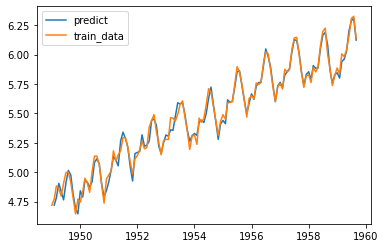

In [20]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

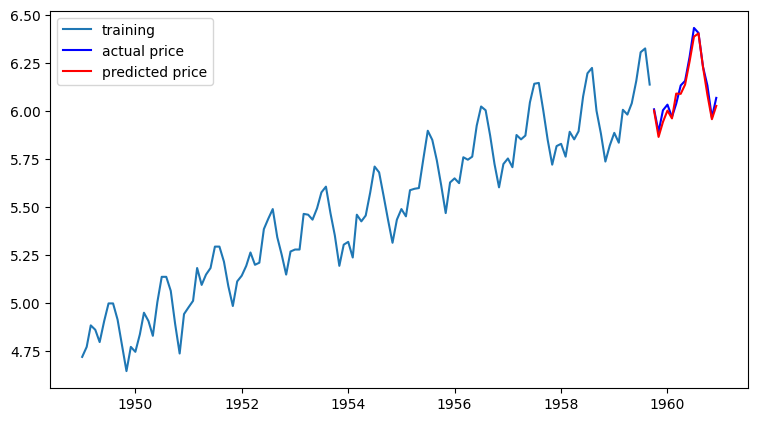

In [21]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있습니다. np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산합니다.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  236.27939252509398
MAE:  12.55810531713422
RMSE:  15.371382258115045
MAPE: 2.76%


최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 10% 정도의 오차율을 보입니다. 썩 만족스럽지 않은데, 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을지 모르겠습니다. p=14을 줄 경우 MAPE가 2% 정도로 내려갑니다